In [2]:
import torch
import torchani
from ani2x_nc1 import CustomEnsemble
from atomic_rhos import *
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchani.units import hartree2kcalmol

/home/nick/TorchANI_sandbox/torchani/models.py:103: UserWarning: The default is now to accept atomic numbers as indexes, do not set periodic_table_index=True. if you need to accept raw indices set periodic_table_index=False
  warnings.warn("The default is now to accept atomic numbers as indexes,"


In [3]:
device = torch.device('cpu')
ani1x = torchani.models.ANI1x().to(device)

/home/nick/TorchANI_sandbox/torchani/models.py:103: UserWarning: The default is now to accept atomic numbers as indexes, do not set periodic_table_index=True. if you need to accept raw indices set periodic_table_index=False
  warnings.warn("The default is now to accept atomic numbers as indexes,"


In [4]:
ds_path = Path.cwd() / '/home/nick/ANI-1x-first-conformers.h5'

In [5]:
ds = ANIDataset(locations=(dataset_path), names=('ANI-1x-first'))
print(len(ds))

3114


In [10]:
df = pd.DataFrame(columns=['Formula','Species','Avg_AE','Stdev','QBC'])
count = 0
formula_list = []
species_list = []
avg_ae_list = []
stdev_list = []
qbc_list = []


for index, formula in enumerate(ds.keys()):
    #print('Molecular formula:\n',formula)
    
    conformer = ds.get_conformers(formula)    
    species = conformer['species']
    #print(species)
    coordinates = conformer['coordinates']
    ani_input = (species,coordinates)
    #mol_e = ani1x(ani_input).energies
    #print('Molecular energy:\n',mol_e.detach().item(), 'Hartree')
    _, energies, qbc_factor = ani1x.energies_qbcs(ani_input)
        
    species_index, ae = ani1x.atomic_energies(ani_input, average=False, with_SAEs=False)
    #print('Atomic energy contributions (no SAEs):\n',ae.detach(),'in Hartree')
    
    avg_ae = ae.mean(0).tolist()
    #print('Average atomic energy contribution:\n',avg_ae[0],'in Hartree')
    
    stdev_ae = ae.std(0).tolist()
    #print('Stdev in atomic energies across the ensemble:\n',stdev_ae.detach()[0],'in Hartree')
    
    coef_var = (ae.std(0)/abs(ae.mean(0))).tolist()
    #print('Coefficient of variation in atomic energies:\n',coef_var[0])
    
    for atoms in avg_ae[0]:
        formula_list.append(formula)
        # Want a chemical formula and qbc factor attached to each atom type
        qbc_list.append(qbc_factor.detach().numpy())
    
    #print(formula_list)
    species_list.extend(species.tolist()[0])
    #print(species_list)
    avg_ae_list.extend(avg_ae[0])
    #print(avg_ae_list)
    stdev_list.extend(stdev_ae[0])
    #print(stdev_list)
    
    
    # Counter to stop iterating:
    #count += 1
    #if count == 25:
    #    break


df['Species'] = species_list
df['Avg_AE'] = avg_ae_list
df['Stdev'] = stdev_list
df['Formula'] = formula_list
df['QBC'] = qbc_list
print(df)

      Formula  Species    Avg_AE     Stdev             QBC
0      C10H10        6  0.010933  0.003716  [0.0006099482]
1      C10H10        6  0.006443  0.003760  [0.0006099482]
2      C10H10        6 -0.019526  0.003301  [0.0006099482]
3      C10H10        6 -0.010780  0.001123  [0.0006099482]
4      C10H10        6 -0.006845  0.001860  [0.0006099482]
...       ...      ...       ...       ...             ...
72745      O3        8  0.077669  0.008417  [0.0011950523]
72746      O4        8  0.082022  0.000702  [0.0017885823]
72747      O4        8  0.084362  0.001346  [0.0017885823]
72748      O4        8  0.082762  0.000811  [0.0017885823]
72749      O4        8  0.083549  0.001007  [0.0017885823]

[72750 rows x 5 columns]


In [22]:
df['QBC']

0        [0.0006099482]
1        [0.0006099482]
2        [0.0006099482]
3        [0.0006099482]
4        [0.0006099482]
              ...      
72745    [0.0011950523]
72746    [0.0017885823]
72747    [0.0017885823]
72748    [0.0017885823]
72749    [0.0017885823]
Name: QBC, Length: 72750, dtype: object

In [19]:
mol_in_ds = len(ds)
atoms_in_ds = len(df['QBC'])
avg_N = atoms_in_ds/mol_in_ds
print(avg_N)

23.36223506743738


In [20]:
avg_qbc_factor = df['QBC'].to_numpy().mean(0).item()
print(hartree2kcalmol(avg_qbc_factor),'kcal/mol avg qbc factor')

0.3911889147755141 kcal/mol avg qbc factor


In [13]:
df_by_species = df.set_index('Species')
h_df = df_by_species.loc[1]
c_df = df_by_species.loc[6]
n_df = df_by_species.loc[7]
o_df = df_by_species.loc[8]

print(h_df,'\n',c_df,'\n',n_df,'\n',o_df)

        Formula    Avg_AE     Stdev              QBC
Species                                             
1        C10H10 -0.006097  0.002806   [0.0006099482]
1        C10H10  0.004476  0.002033   [0.0006099482]
1        C10H10  0.000894  0.002555   [0.0006099482]
1        C10H10 -0.002350  0.002346   [0.0006099482]
1        C10H10  0.000419  0.002092   [0.0006099482]
...         ...       ...       ...              ...
1         HN3O2  0.006429  0.002554  [0.00049992703]
1           HNO  0.008102  0.003244  [0.00057561195]
1          HNO2  0.010005  0.002982   [0.0008901718]
1          HNO3  0.007976  0.003129  [0.00097573106]
1          HNO4  0.006654  0.002561   [0.0009029554]

[36329 rows x 4 columns] 
         Formula    Avg_AE     Stdev             QBC
Species                                            
6        C10H10  0.010933  0.003716  [0.0006099482]
6        C10H10  0.006443  0.003760  [0.0006099482]
6        C10H10 -0.019526  0.003301  [0.0006099482]
6        C10H10 -0.0107

In [8]:
h_energies = h_df['Avg_AE'].to_numpy()
h_stdev = h_df['Stdev'].to_numpy()

c_energies = c_df['Avg_AE'].to_numpy()
c_stdev = c_df['Stdev'].to_numpy()

n_energies = n_df['Avg_AE'].to_numpy()
n_stdev = n_df['Stdev'].to_numpy()

o_energies = o_df['Avg_AE'].to_numpy()
o_stdev = o_df['Stdev'].to_numpy()

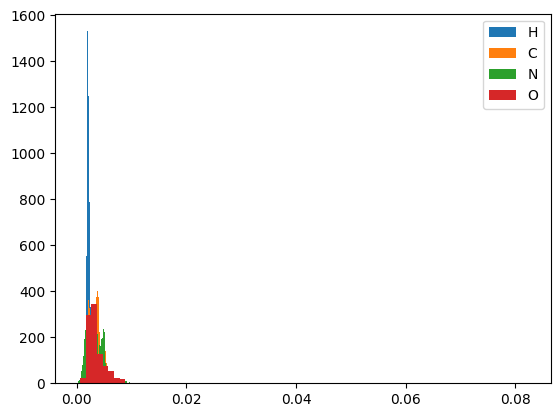

In [9]:
plt.hist(h_stdev, bins=(math.isqrt(len(h_df))), label='H', density=True)
plt.hist(c_stdev, bins=(math.isqrt(len(c_df))), label='C', density=True)
plt.hist(n_stdev, bins=(math.isqrt(len(n_df))), label='N', density=True)
plt.hist(o_stdev, bins=(math.isqrt(len(o_df))), label='O', density=True)
plt.legend(loc='upper right')
plt.show()

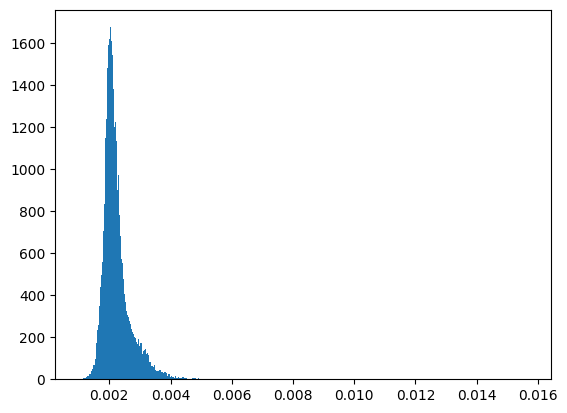

Avg energy: 0.001942363031556303
Avg stdev: 0.002236941061836316


In [10]:
# Hydrogen histograms
plt.hist(h_stdev, bins=500)#, range=[0.001,0.0055])
plt.show()
print('Avg energy:', np.mean(h_energies))
print('Avg stdev:',np.mean(h_stdev))

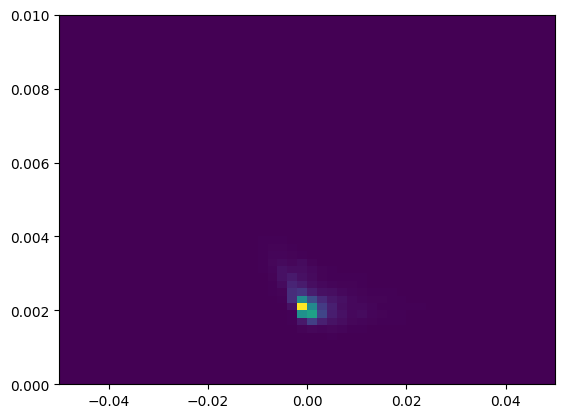

In [11]:
x = h_energies
y = h_stdev
plt.hist2d(x,y,bins=(50,50),range=[[-0.05,0.05],[0,0.01]])
plt.show()

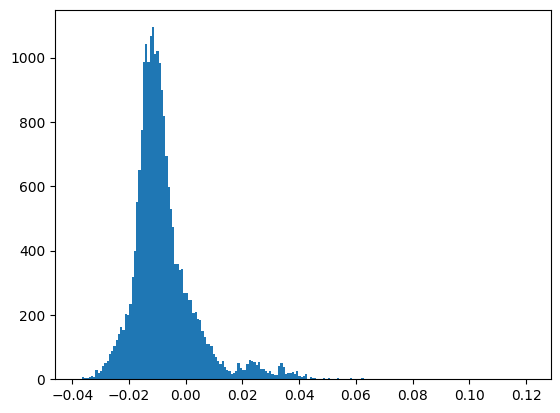

Avg energy: -0.007779802839597099
Avg stdev: 0.0032455473730245627


In [12]:
# C energies
plt.hist(c_energies, bins=200)
plt.show()
print('Avg energy:',np.mean(c_energies))
print('Avg stdev:',np.mean(c_stdev))

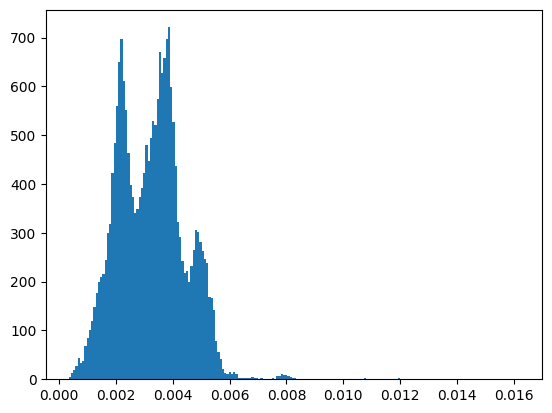

Avg energy: -0.007779802839597099
Avg stdev: 0.0032455473730245627


In [13]:
# Carbon histograms

plt.hist(c_stdev, bins=200) #, range=[0.,0.014])
plt.show()
print('Avg energy:',np.mean(c_energies))
print('Avg stdev:',np.mean(c_stdev))

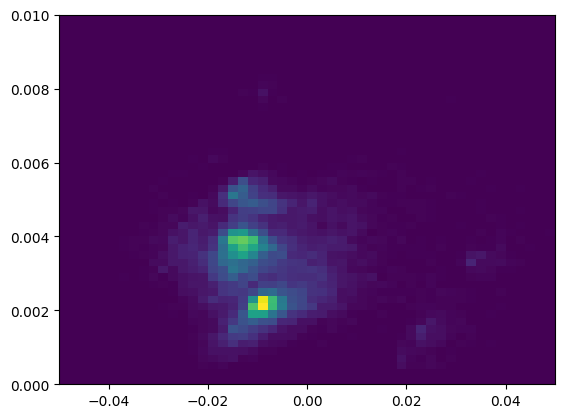

In [14]:
x = c_energies
y = c_stdev
plt.hist2d(x,y,bins=(50,50),range=[[-0.05,0.05],[0,0.01]])
plt.show()

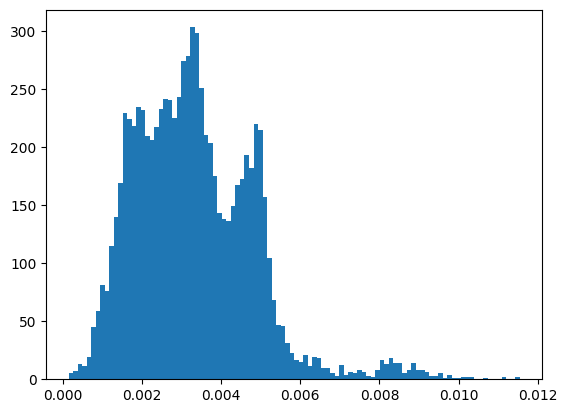

Avg energy: -0.010455107705421855
Avg stdev: 0.003315394506453939


In [15]:
# Nitrogen histograms

plt.hist(n_stdev, bins=100) #, range=[0.0,0.0175])
plt.show()
print('Avg energy:',np.mean(n_energies))
print('Avg stdev:',np.mean(n_stdev))

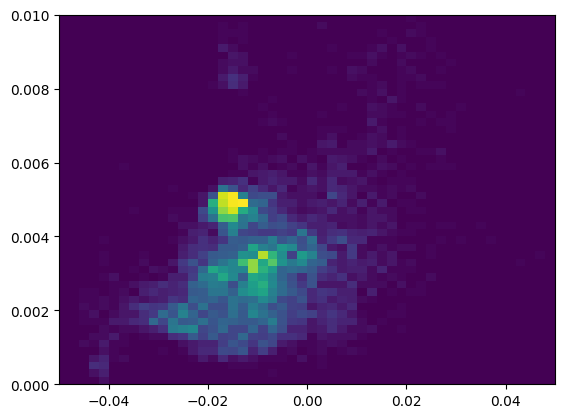

In [16]:
x = n_energies
y = n_stdev
plt.hist2d(x,y,bins=(50,50),range=[[-0.05,0.05],[0,0.01]])
plt.show()

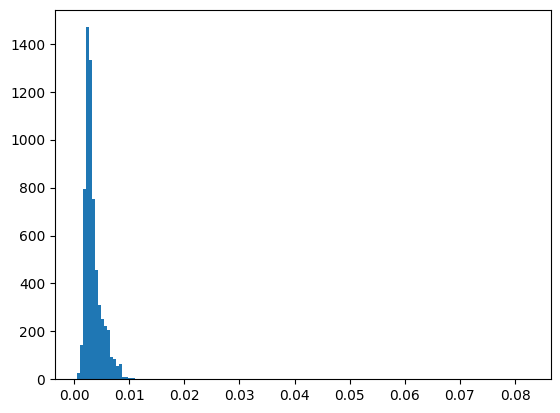

Avg energy: 0.005027933762410067
Avg stdev: 0.0035419302443728735


In [17]:
# Oxygen histograms

plt.hist(o_stdev, bins=150)#, range=[0.001,0.01])
plt.show()
print('Avg energy:',np.mean(o_energies))
print('Avg stdev:',np.mean(o_stdev))

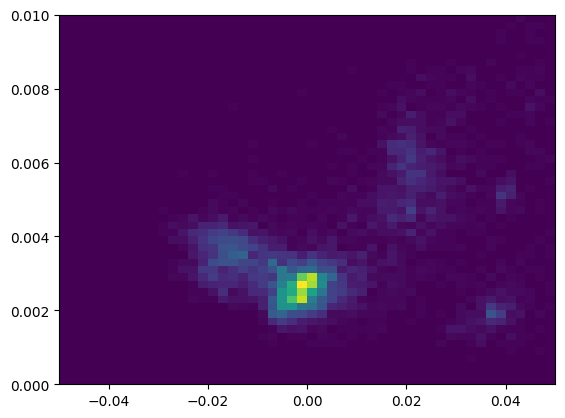

In [18]:
x = o_energies
y = o_stdev
plt.hist2d(x,y,bins=(50,50),range=[[-0.05,0.05],[0,0.01]])#, cmap=plt.cm.Reds)
plt.show()

In [19]:
avg_qbc = df['QBC'].mean().item()
avg_atomic_stdev = df['Stdev'].mean()
print('Avg atomic e stdev:',hartree2kcalmol(avg_atomic_stdev), 'kcal/mol')
print('Avg qbc factor:    ',hartree2kcalmol(avg_qbc), 'kcal/mol')

Avg atomic e stdev: 1.7416172124103995 kcal/mol
Avg qbc factor:     0.3911889147755141 kcal/mol
